In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense



In [15]:

data_with_date = pd.read_csv('Input/rf_api_90days.csv', index_col='date', usecols=['date', 'rainfall','gwl','api'])
data = data_with_date[['rainfall', 'api', 'gwl']]

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print(data.shape, data_scaled.shape)
print(data_scaled[0])


(699, 3) (699, 3)
[ 1.89858348 -0.93518691 -0.67828701]


In [16]:

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]
print(train_data.shape)
print(test_data.shape)



(468, 3)
(231, 3)


In [25]:

# Reshape the data for LSTM input
train_X = np.reshape(train_data[:, :-1], (train_data.shape[0], train_data.shape[1] - 1, 1))
test_X = np.reshape(test_data[:, :-1], (test_data.shape[0], test_data.shape[1] - 1, 1))
train_Y = train_data[:, 2]
test_Y = test_data[:, 2]
print(train_X.shape)


(468, 2, 1)


In [33]:
# Define the LSTM model
model = Sequential()

#Define the input shape according to the shape of each sample in train X
input_shp=(train_X.shape[1],train_X.shape[2])

model.add(LSTM(4, input_shape=input_shp, return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# Train the model
model.fit(train_X, train_Y, epochs=10, batch_size=1, verbose=2)

test_predict = model.predict(test_X)

print(test_predict.shape)
print(test_Y.shape)

Epoch 1/10
468/468 - 1s - 2ms/step - loss: 0.8822
Epoch 2/10
468/468 - 0s - 428us/step - loss: 0.6233
Epoch 3/10
468/468 - 0s - 426us/step - loss: 0.5298
Epoch 4/10
468/468 - 0s - 429us/step - loss: 0.5140
Epoch 5/10
468/468 - 0s - 422us/step - loss: 0.5098
Epoch 6/10
468/468 - 0s - 422us/step - loss: 0.5039
Epoch 7/10
468/468 - 0s - 429us/step - loss: 0.4985
Epoch 8/10
468/468 - 0s - 421us/step - loss: 0.4957
Epoch 9/10
468/468 - 0s - 420us/step - loss: 0.4920
Epoch 10/10
468/468 - 0s - 419us/step - loss: 0.4902
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(231, 1)
(231, 1)


In [20]:

# from keras.metrics import Accuracy

# model.evaluate(test_X, test_Y, verbose=0)

out_Y = [val[0] for val in test_predict]
out_Y = np.array(out_Y)
print(out_Y.shape)


(231,)


In [30]:
#reshape test_y
test_Y= np.reshape(test_Y,(test_X.shape[0], 1))
print(test_Y.shape)

#combine the text_x and text_y 
observed= np.array((test_X[:, 0], test_X[:, 1], test_Y)).T
print(observed.shape)

(231, 1)
(1, 231, 3)


In [31]:

#reshape out_y
out_Y= np.reshape(out_Y,(test_X.shape[0], 1))
print(out_Y.shape)

#combine test_Y and out_y
predict= np.array((test_X[:, 0], test_X[:, 1], out_Y)).T
print(predict.shape)


(231, 1)
(1, 231, 3)


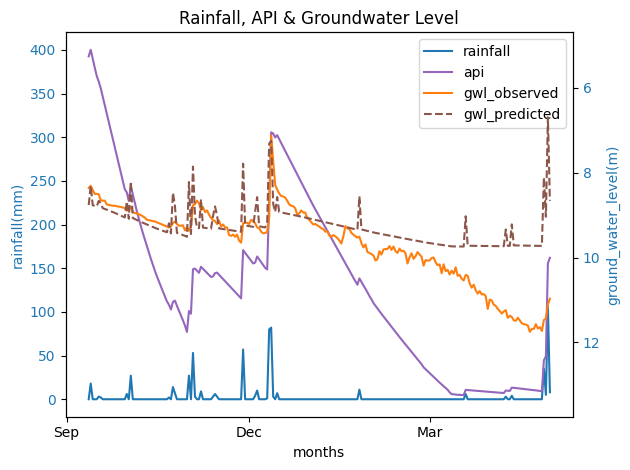

In [24]:

# Reshape predict to a 2D array
predict = predict.reshape(-1, predict.shape[-1])
observed = observed.reshape(-1, observed.shape[-1])
# Now you can use inverse_transform without any issues

#plt.plot(scaler.inverse_transform(predict, observed))
predict_unscaled = scaler.inverse_transform(predict)
observed_unscaled = scaler.inverse_transform(observed)

data.index = pd.to_datetime(data.index, format='%d/%m/%Y')

df = pd.DataFrame()
df['rainfall'] = data['rainfall'][train_size:len(data)]
df['api'] = data['api'][train_size:len(data)]
df['gwl_obs'] = observed_unscaled[:, 2]
df['gwl_prd'] = predict_unscaled[:, 2]
df.index = data.index[train_size:]
# print(df)


import matplotlib.dates as dates


# df = df[len(df) - int(366/2):]
fig = plt.figure()
ax1 = fig.add_subplot()
color = 'tab:blue'
ax1.set_xlabel('months')
ax1.set_ylabel('rainfall(mm)', color=color)

rainfall = ax1.plot(df.index, df['rainfall'], color=color, label='rainfall')
api = ax1.plot(df.index, df['api'], color='tab:purple', label='api')

ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_locator(dates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(dates.DateFormatter('%b'))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('ground_water_level(m)', color=color)  # we already handled the x-label with ax1
gwl_obs = ax2.plot(df.index, df['gwl_obs'], color='tab:orange', label='gwl_observed')
gwl_prd = ax2.plot(df.index, df['gwl_prd'], color='tab:brown', linestyle='dashed', label='gwl_predicted')

ax2.set_ylim(max(df['gwl_prd'].max(), df['gwl_obs'].max()) + 2, min(df['gwl_prd'].min(), df['gwl_obs'].min()) - 2)
ax2.tick_params(axis='y', labelcolor=color)

# Combining lines and labels from all plots to create common legend
lines = rainfall + api + gwl_obs + gwl_prd
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")

plt.title('Rainfall, API & Groundwater Level')
fig.tight_layout()  #otherwise the right y-label is slightly clipped

# save the output file
plt.savefig('Output/plot/lstm_rf_api_90d_2.png')

plt.show()
